# Differentiated Bertrand Competition

A simple model of ***differentiated*** Bertrand competition (i.e. it behaves like a Cournot model, but firms are choosing prices, not quantities). 

**Note:** This is rather different from the ***pure Bertrand*** model. In that model, products are ***perfect substitutes*** to consumers, so they simply choose the cheapest alternative. As we shall see, the differentiated Bertrand model has quite a bit of taste heterogeneity, implying that there is no discontinuity at the minimum price. 

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 

from scipy.optimize import minimize

# Model 

Firms maximize profits given by 
$$ \pi(p^i, p^j) = s(p^i,p^j)(p^i - c), $$ 
where $c$ are symmetric marginal cost, and $(p^i,p^j)$ are the own and competitor prices, and where the market share function, $s(\cdot,\cdot)$, is given by 

$$ s^1(p^1,p^2) = \frac{\exp(\gamma_1 - \delta_1 p^1)}{1 + \exp(\gamma_1 - \delta_1 p^1) + \exp(\gamma_2 - \delta_2 p^2)}. $$

Conveniently, we may choose to *max rescale* the utilities. Denote 
$$ v_{i0} \equiv 0, v_{i1} \equiv \gamma_1 - \delta_1 p^1, v_{i2} \equiv \gamma_2 - \delta_2. $$
Then we can use that 
$$ \frac{\exp(v_{ij})}{\sum_{k=0}^2 \exp(v_{ik})} = \frac{\exp(v_{ij} - M)}{\sum_{k=0}^2 \exp(v_{ik} - M)} \quad \text{for any } M \in \mathbb{R}.$$
This equality holds analytically, but there is a numerical difference: since round-up errors are much worse for our applications, it is better to have small numbers enter into the exponential functions. Hence, we can e.g. set 
$$M := \max_{k=0,1,2} v_{ik},$$
and then we will only ever have round-down errors. 




## Where does this come from? 
This comes from a model where the consumer gets indirect utility 
$$ u_{ij} = 1 - \delta^j p^j + \varepsilon_{ij}$$ 
from choosing products $j = 1,2$, but gets 
$$ u_{i0} = \varepsilon_{ij}$$ 
from choosing the outside option, where 
$$ \varepsilon_{ij} \sim \text{IID Extreme Value Type I}. $$ 
Under this assumption on the error term, it can be shown that the probability that consumer $i$ chooses alternative $j$ among the options $j \in \{0, 1, 2\}$ takes the form given earlier, and 
$$ \Pr(i \text{ chooses }j = 0) = \frac{1}{1 + \exp(\gamma_1 - \delta_1 p^1) + \exp(\gamma_2 - \delta_2 p^2)} $$
(since $\exp(0) = 1$, which appears both in the numerator and the denominator). 

In [2]:
# assign parameter values 
c = 0.5 
gamma1 = 1.0
gamma2 = 1.0
delta1 = 3.0 
delta2 = 3.0 

def u(p1,p2): 
    u1 = gamma1 - delta1*p1
    u2 = gamma2 - delta2*p2
    return u1,u2

def s(p1, p2): 
    u1,u2 = u(p1,p2)
    
    # max-rescaling
    M = np.amax([0.0,u1,u2])
    eu0 = np.exp(0.0 - M) # outside option 
    eu1 = np.exp(u1  - M)
    eu2 = np.exp(u2  - M)
    
    # denominator 
    denom = eu0 + eu1 + eu2 
    
    # market shares 
    s1 = eu1 / denom 
    s2 = eu2 / denom 
    
    return s1, s2
    
def s1(p1, p2): 
    s1,s2 = s(p1, p2)
    return s1,s2

def pi(p1, p2, i): 
    S1,S2 = s1(p1,p2)
    if i == 0: 
        profit = (p1 - c)*S1
    elif i == 1: 
        profit = (p2 - c)*S2
    else: 
        profit = np.nan 
        
    return profit

Compute profits to player 1 for prices (0.8, 0.9). 

In [3]:
i = 0
pi(.8, .9, i)

0.051759671949551465

Plot payoffs for player 1 for different values of player 2's action (price). 

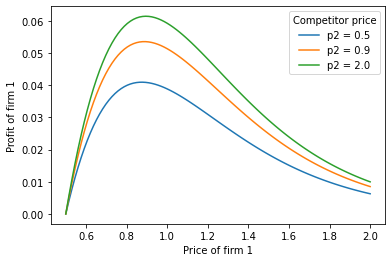

In [4]:
p2 = 0.8 # fix player 2's price for this plot 

fig, ax = plt.subplots()

for p2 in [0.5, 0.9, 2.0]: 
    pp = np.linspace(c, 2., 100)
    ff = [pi(p, p2, 0) for p in pp]
    ax.plot(pp, ff, label=f'p2 = {p2}'); 
plt.xlabel('Price of firm 1'); plt.ylabel('Profit of firm 1'); 
plt.legend(title='Competitor price'); 

From the graph above, it is clear that firm 1's profit increases overall when firm 2 raises the price (because the two products are substitutes). However, the optimal price also change, although not by much. 

# Manual iterative best response

**Proposition:** The firms will always choose a price $p^i \in (c; \infty)$. 

**Proof:** Given our game setup, we know that for $p^i \le c$, we will have $\pi^i \le 0$. Similarly, due to the demand function, when $p^i \to \infty$, the market share will tend to zero, $ s^i \to 0$. However, since the profit is a product then, $\pi^i = (s^i - c)p^i$, it depends on the relative speed of $p^i \to \infty$  and $ s^i \to 0$ which one will dominate. However, it turns out that the latter dominates so that $ \pi^i \to 0$  as $p^i \to \infty$. 

**Best response:** We cannot generally solve the profit maximization problem in the same way as we did with a simple linear demand curve. However, there is nothing wrong with taking `scipy.optimize.minimize` for a spin! We just have to use the negative of profits as the objective function since it is minimizing and we want to maximize profits. The algorithm then works as follows: 
1. Initialize `p2` to some value
2. Find `p1` that minimizes `-pi(p, p2, i=0)` wrt. `p` - call the minimizer `p1`. 
3. Find `p2` that minimizes `-pi(p1, p, i=1)` wrt. `p` - call the minimizer `p2`. 
4. repeat 2-3 until nothing changes. 

**Equilibrium:** The pure strategy Nash equilibrium occurs when both firms are choosing a price that is a best response to the price of the competitor. 

In [5]:
# initialization 
p2 = 0.6

In [6]:
f_ = lambda p: -pi(p, p2, i=0) # anonymous function of one variable

In [7]:
res = minimize(f_, x0=p2)

/Users/mrz577/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
p1 = res['x'][0]
print(f'BR1(p2={p2:5.2f}) = {p1:5.2f}')

BR1(p2= 0.60) =  0.88


In [9]:
f_ = lambda p: -pi(p1, p, i=1)
res = minimize(f_, x0=p2)
p2 = res['x'][0]
print(f'BR2(p1={p1:5.2f}) = {p2:5.2f}')

BR2(p1= 0.88) =  0.89


Now, we have taken the first two steps in the **iterated best response algorithm**. Continuing is left as an exercise to you. 